In [4]:
import pandas as pd
import numpy as np

In [5]:
from corpus_reading import read_dump
import corpus_utils

chords_tsv = 'data/chord_list.tsv'
notes_tsv = 'data/note_list.tsv'
measures_tsv = 'data/measure_list.tsv'
files_tsv = 'data/file_list.tsv'

chords_df = read_dump(chords_tsv)
notes_df = read_dump(notes_tsv, index_col=[0,1,2])
measures_df = read_dump(measures_tsv)
files_df = read_dump(files_tsv, index_col=0)

# Bugfixes
measures_df.loc[(685, 487), 'next'][0] = 488

/home/apmcleod/miniconda3/envs/harmony/lib/python3.8/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
files_df

,extension,filename,md5,name,rel_path,subcorpus
id,,,,,,
0,.mscx,BWV806_01_Prélude.mscx,e81d2b409a3c696e733ac86b86f522ee,BWV806_01_Prélude,annotations/Bach_Suites/English Suites,English Suites
1,.mscx,BWV806_02_Allemande.mscx,891f360ce282304a05b6172a67961b1a,BWV806_02_Allemande,annotations/Bach_Suites/English Suites,English Suites
2,.mscx,BWV806_03_Courante_I.mscx,30885cb1c729ef726e7d7f6dbb96c71b,BWV806_03_Courante_I,annotations/Bach_Suites/English Suites,English Suites
3,.mscx,BWV806_04_Courante_II.mscx,10f21162c887d978f95ffdd34c03bc50,BWV806_04_Courante_II,annotations/Bach_Suites/English Suites,English Suites
4,.mscx,BWV806_05_Double_I.mscx,afe9dccb3ee6a23457c84450fdf33a65,BWV806_05_Double_I,annotations/Bach_Suites/English Suites,English Suites
...,...,...,...,...,...,...
692,.mscx,n15op132_05.mscx,99de9a044640c174120817a0126f74cc,n15op132_05,data/mscx,mscx
693,.mscx,n16op135_01.mscx,a60fdfa4c0a2a9b80f0884859fbb4ae4,n16op135_01,data/mscx,mscx
694,.mscx,n16op135_02.mscx,196149b8165016829d4075e0b6dc617b,n16op135_02,data/mscx,mscx


In [7]:
chords_df

mc   mn onset chords  chord key pedal numeral  form figbass  \
id  chord_id                                                                 
0   0           0    1     0   .A.I      I   I  <NA>       I  <NA>    <NA>   
    1           0    1   3/8     V7     V7   I  <NA>       V  <NA>       7   
    2           0    1   3/4      I      I   I  <NA>       I  <NA>    <NA>   
    3           0    1   9/8     V7     V7   I  <NA>       V  <NA>       7   
    4           1    2     0      I      I   I  <NA>       I  <NA>    <NA>   
...           ...  ...   ...    ...    ...  ..   ...     ...   ...     ...   
696 160058    280  281   1/2      I      I   I  <NA>       I  <NA>    <NA>   
    160059    280  281   3/4     I6     I6   I  <NA>       I  <NA>       6   
    160060    281  282     0  V(64)  V(64)   I  <NA>       V  <NA>    <NA>   
    160061    281  282   1/2     V7     V7   I  <NA>       V  <NA>       7   
    160062    282  283     0    I\\      I   I  <NA>       I  <NA>    <NA>   

              ... relativeroot phraseend globalkey bass_step mc_next  \
id  chord_id  ...                                                      
0   0         ...         <NA>      <NA>         A         1       0   
    1         ...         <NA>      <NA>         A         5       0   
    2         ...         <NA>      <NA>         A         1       0   
    3         ...         <NA>      <NA>         A         5       1   
    4         ...         <NA>      <NA>         A         1       1   
...           ...          ...       ...       ...       ...     ...   
696 160058    ...         <NA>      <NA>         f         1     280   
    160059    ...         <NA>      <NA>         f         3     281   
    160060    ...         <NA>      <NA>         f         5     281   
    160061    ...         <NA>      <NA>         f         5     282   
    160062    ...         <NA>        \\         f         1     283   

              onset_next next_chord_id  chord_length globalminor  localminor  
id  chord_id                                                                  
0   0                3/8             1           3/8       False       False  
    1                3/4             2           3/8       False       False  
    2                9/8             3           3/8       False       False  
    3                  0             4           3/8       False       False  
    4                3/8             5           3/8       False       False  
...                  ...           ...           ...         ...         ...  
696 160058           3/4        160059           1/4        True       False  
    160059             0        160060           1/4        True       False  
    160060           1/2        160061           1/2        True       False  
    160061             0        160062           1/2        True       False  
    160062             0          <NA>             1        True       False  

[142511 rows x 21 columns]

In [8]:
measures_df

section  keysig timesig duration act_dur offset  voices  \
id  mc                                                             
0   0          0       3    12/8      3/2     3/2      0       4   
    1          0       3    12/8      3/2     3/2      0       5   
    2          0       3    12/8      3/2     3/2      0       6   
    3          0       3    12/8      3/2     3/2      0       3   
    4          0       3    12/8      3/2     3/2      0       4   
...          ...     ...     ...      ...     ...    ...     ...   
696 278       13      -1     4/4        1       1      0       4   
    279       13      -1     4/4        1       1      0       4   
    280       13      -1     4/4        1       1      0       4   
    281       13      -1     4/4        1       1      0       4   
    282       13      -1     4/4        1       1      0       4   

              repeats  volta barline  numbering_offset  dont_count marker  \
id  mc                                                                      
0   0    firstMeasure   <NA>    <NA>              <NA>        <NA>   <NA>   
    1            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    2            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    3            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    4            <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
...               ...    ...     ...               ...         ...    ...   
696 278          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    279          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    280          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    281          <NA>   <NA>    <NA>              <NA>        <NA>   <NA>   
    282   lastMeasure   <NA>     end              <NA>        <NA>   <NA>   

          mn   next  
id  mc               
0   0      1    [1]  
    1      2    [2]  
    2      3    [3]  
    3      4    [4]  
    4      5    [5]  
...      ...    ...  
696 278  279  [279]  
    279  280  [280]  
    280  281  [281]  
    281  282  [282]  
    282  283     []  

[75318 rows x 15 columns]

In [9]:
notes_df

mc   mn onset duration gracenote nominal_duration scalar  \
id  section ix                                                               
0   0       0      0    1     0     1/16      <NA>             1/16      1   
            1      0    1  1/16     1/16      <NA>             1/16      1   
            2      0    1   1/8     1/16      <NA>             1/16      1   
            3      0    1  3/16     1/16      <NA>             1/16      1   
            4      0    1   1/4     1/16      <NA>             1/16      1   
...              ...  ...   ...      ...       ...              ...    ...   
696 13      309  282  283     0      1/4      <NA>              1/4      1   
            310  282  283     0      1/4      <NA>              1/4      1   
            311  282  283     0      1/4      <NA>              1/4      1   
            312  282  283     0      1/4      <NA>              1/4      1   
            313  282  283     0      1/4      <NA>              1/4      1   

                 tied  tpc  midi  staff  voice  volta  octaves note_names  \
id  section ix                                                              
0   0       0    <NA>    3    45      2      2   <NA>        2          A   
            1    <NA>    7    49      2      2   <NA>        3         C#   
            2    <NA>    4    52      2      2   <NA>        3          E   
            3    <NA>    3    57      2      1   <NA>        3          A   
            4    <NA>    8    56      2      1   <NA>        3         G#   
...               ...  ...   ...    ...    ...    ...      ...        ...   
696 13      309  <NA>   -1    53      3      1   <NA>        3          F   
            310  <NA>    3    69      1      1   <NA>        4          A   
            311  <NA>    3    69      2      1   <NA>        4          A   
            312  <NA>   -1    77      2      1   <NA>        5          F   
            313  <NA>   -1    89      1      1   <NA>        6          F   

                 keysig timesig  beats  
id  section ix                          
0   0       0         3    12/8      1  
            1         3    12/8  1.1/6  
            2         3    12/8  1.1/3  
            3         3    12/8  1.1/2  
            4         3    12/8  1.2/3  
...                 ...     ...    ...  
696 13      309      -1     4/4      1  
            310      -1     4/4      1  
            311      -1     4/4      1  
            312      -1     4/4      1  
            313      -1     4/4      1  

[1079574 rows x 18 columns]

In [13]:
import harmonic_inference_data as hid
import importlib
importlib.reload(hid)

train_dataset, valid_dataset, test_dataset = hid.get_train_valid_test_splits(
    chords_df=chords_df, notes_df=notes_df, measures_df=measures_df, files_df=files_df,
    seed=0, h5_directory='data', h5_prefix='811split', make_dfs=True
)

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (0, 0, 105) and duration 5/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (0, 0, 446) and duration 1/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (1, 0, 233) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (1, 0, 359) and duration 1/8. Returning None.
  warnings.war

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (228, 0, 46) and duration 1/24. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (228, 0, 49) and duration 1/6. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (228, 0, 50) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (228, 0, 381) and duration 3/16. Returning None.
  warnin

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (289, 0, 1049) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (290, 0, 437) and duration 3/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (290, 0, 953) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (290, 0, 954) and duration 1/16. Returning None.
  warn

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (376, 1, 405) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (376, 1, 454) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (376, 1, 596) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (377, 0, 1159) and duration 1/16. Returning None.
  

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (398, 0, 26) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (398, 1, 159) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (398, 2, 126) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (398, 2, 2259) and duration 1/4. Returning None.
  warning

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (531, 2, 117) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (531, 2, 119) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (531, 2, 120) and duration 1/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (532, 1, 186) and duration 1/8. Returning None.
  wa

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (635, 0, 1) and duration 1. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (635, 1, 1988) and duration 5/2. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (642, 3, 137) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (645, 8, 249) and duration 1/8. Returning None.
  warnings

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (672, 2, 1450) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (672, 2, 1451) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (672, 2, 1452) and duration 1/8. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (672, 2, 1453) and duration 1/8. Returning None.
  w

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (693, 0, 1138) and duration 3/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (693, 0, 1177) and duration 3/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (693, 1, 1593) and duration 3/16. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "
/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (693, 1, 1634) and duration 3/16. Returning None.

/mnt/c/Users/apmcl/Documents/GitHub/harmonic-inference/corpus_utils.py:424: UserWarning: No matching tied note found for note index (688, 4, 354) and duration 1/4. Returning None.
  warnings.warn(f"No matching tied note found for note index ({note_id}, {note_section}, "


In [19]:
import harmonic_inference_models as him
import harmonic_utils
import importlib
importlib.reload(him)

model = him.MusicScoreModel(len(train_dataset[0]['notes'][0]), len(harmonic_utils.CHORD_TYPES) * 12, dropout=0.2)

In [20]:
import model_trainer
import importlib
importlib.reload(model_trainer)

from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR

optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001)
criterion = CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
schedule_var = 'valid_loss'

trainer = model_trainer.ModelTrainer(model, train_dataset=train_dataset, valid_dataset=valid_dataset,
                                     test_dataset=test_dataset, seed=0, num_epochs=100, early_stopping=20,
                                     optimizer=optimizer, scheduler=scheduler, schedule_var=schedule_var,
                                     criterion=criterion,
                                     log_every=1, log_file=None,
                                     save_every=10, save_dir='checkpoints', save_prefix='checkpoint',
                                     resume='checkpoints/best.pth.tar')

In [ ]:
trainer.train()

In [21]:
trainer = model_trainer.ModelTrainer(model, train_dataset=train_dataset, valid_dataset=valid_dataset,
                                     test_dataset=test_dataset, seed=0, num_epochs=100, early_stopping=20,
                                     optimizer=optimizer, scheduler=scheduler, schedule_var=schedule_var,
                                     criterion=criterion,
                                     log_every=1, log_file=None,
                                     save_every=10, save_dir='checkpoints', save_prefix='checkpoint',
                                     resume='checkpoints/best.pth.tar')
loss, acc, outputs, labels = trainer.evaluate()

In [22]:
print(loss, acc)

1.2434561159001356 0.6791945331732386


In [23]:
import harmonic_utils

label_strings = harmonic_utils.get_one_hot_labels()

conf_mat = np.zeros((len(label_strings), len(label_strings)))

for target, out in zip(labels, outputs):
    conf_mat[target, out.argmax()] += 1
    
# Normalize rows
conf_mat /= np.sum(conf_mat, axis=1, keepdims=True)
conf_mat = np.where(np.isnan(conf_mat), 0, conf_mat)

<ipython-input-23-3f1703b1c585>:11: RuntimeWarning: invalid value encountered in true_divide
  conf_mat /= np.sum(conf_mat, axis=1, keepdims=True)


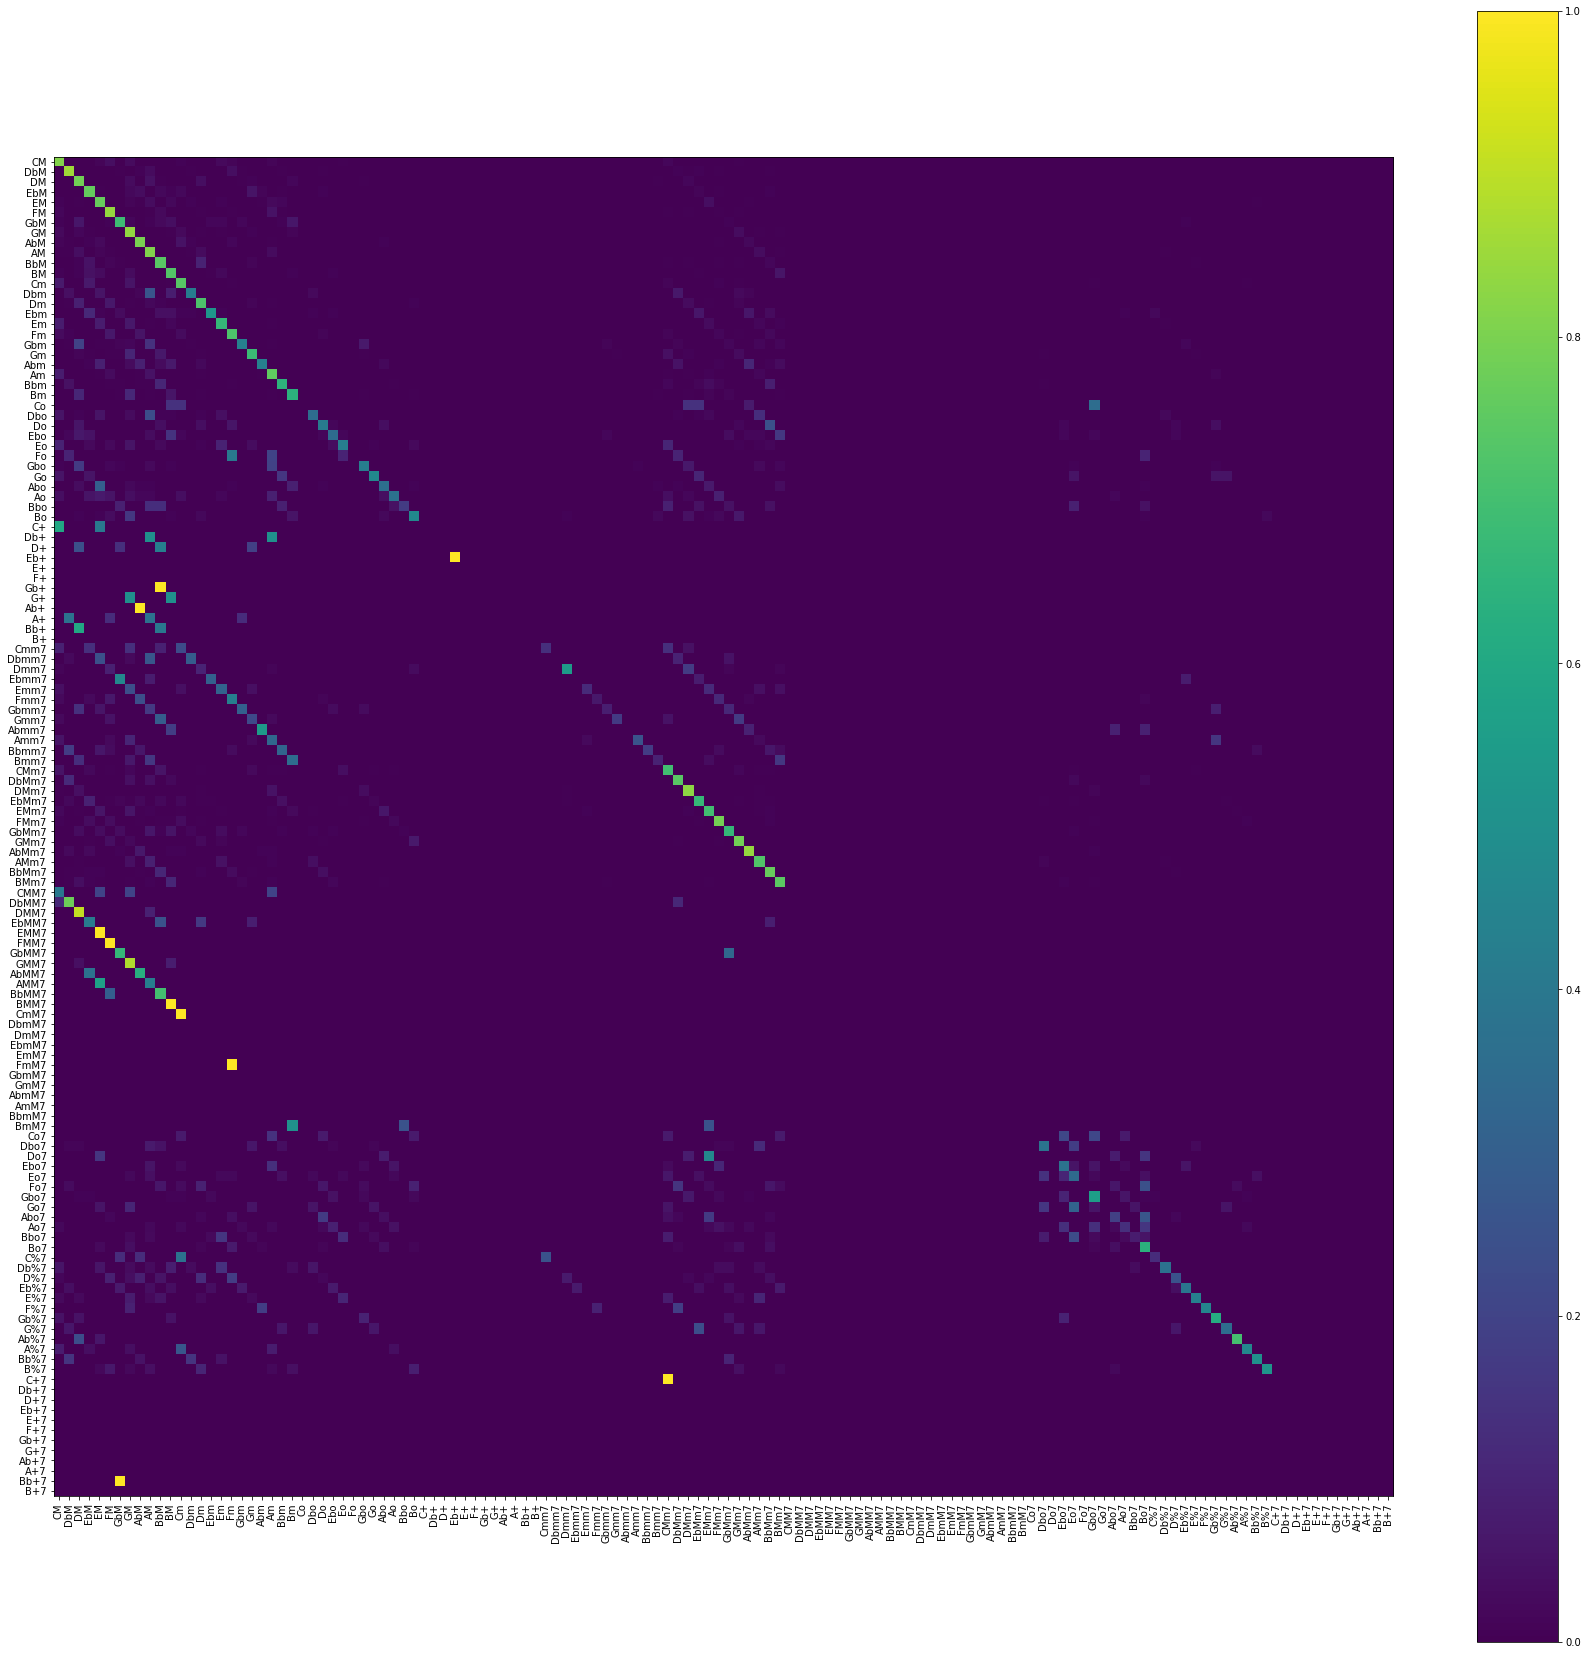

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,30))
plt.imshow(conf_mat, interpolation='none')
plt.colorbar()
plt.xticks(ticks=list(range(len(label_strings))), labels=label_strings, rotation=90, fontsize=10)
plt.yticks(ticks=list(range(len(label_strings))), labels=label_strings, fontsize=10)
plt.show()

In [36]:
def get_correct_and_incorrect_indexes(labels, outputs):
    correct = []
    incorrect = []
    
    for index in range(len(labels)):
        if outputs[index].argmax() == labels[index]:
            correct.append(index)
        else:
            incorrect.append(index)
            
    return correct, incorrect

correct, incorrect = get_correct_and_incorrect_indexes(labels, outputs)
print('Incorrect: ' + str(len(incorrect)))
print('Correct: ' + str(len(correct)))

Incorrect: 4413
Correct: 9343


In [33]:
import harmonic_utils

def print_result(index, labels, outputs, limit=None):
    label_strings = harmonic_utils.get_one_hot_labels()
    if limit is None:
        limit = len(label_strings)

    print(f'Correct: {labels[index]} ({label_strings[labels[index]]})')
    print(f'Guessed: {outputs[index].argmax()} ({label_strings[outputs[index].argmax()]})')
    print('\n'.join([f'{label_string}: {output}'
                     for output, label_string in sorted(zip(outputs[index], label_strings), reverse=True)[:limit]]))
    
print_result(incorrect[0], labels, outputs, limit=10)

Correct: 4 (EM)
Guessed: 0 (CM)
CM: 4.143009662628174
EM: 4.050893783569336
Em: 3.7437305450439453
AM: 3.4725501537323
Eo: 3.3093154430389404
Am: 3.0515553951263428
CMm7: 2.7316694259643555
Dbo: 2.3504838943481445
GbMm7: 2.1121203899383545
AMm7: 2.1083521842956543


In [34]:
import harmonic_utils

def print_input(index, dataset):
    label_strings = harmonic_utils.get_one_hot_labels()

    chord_id = dataset[index]['chord_index']
    note_ids = dataset[index]['note_indexes']
    print(dataset.chords.loc[tuple(chord_id)])
    print(dataset.notes.loc[[(chord_id[0], note_id[0], note_id[1]) for note_id in note_ids]])
    
print_input(incorrect[0], train_dataset)

mc                   0
mn                   1
onset                0
chords            .A.I
chord                I
key                  I
pedal             <NA>
numeral              I
form              <NA>
figbass           <NA>
changes           <NA>
relativeroot      <NA>
phraseend         <NA>
globalkey            A
bass_step            1
mc_next              0
onset_next         3/8
next_chord_id        1
chord_length       3/8
globalminor      False
localminor       False
Name: (0, 0), dtype: object
               mc  mn onset duration gracenote nominal_duration scalar  tied  \
id section ix                                                                  
0  0       0    0   1     0     1/16      <NA>             1/16      1  <NA>   
           1    0   1  1/16     1/16      <NA>             1/16      1  <NA>   
           2    0   1   1/8     1/16      <NA>             1/16      1  <NA>   
           3    0   1  3/16     1/16      <NA>             1/16      1  <NA>   
         